#1

In [505]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1000.0 # Uniform load [N/m]
P = 1000.0           # Point load [N]
a = L / 2            # Load applied at midspan
hinge_loc = L / 2.

colloc_width = L / 4.
colloc_density = 20

dl = 0.01 * L

Noise = False
USE_COLLOC = False

In [506]:

x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
 w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
 return w

def w_point_load(x, L, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return w

def w_udl_hinge(x, hinge_loc, L, Q):
  x_left, x_right = x[x <= hinge_loc], x[hinge_loc < x]
  return np.concatenate([w(x_left, hinge_loc, Q), w(x_right - x_right[0], L - hinge_loc, Q)[::-1]])

def w_udl_hinge(x, hinge_loc, L, q):
    x = np.asarray(x)
    w_out = np.zeros_like(x, dtype=float)

    left  = x <= hinge_loc          # choose one side to hold the equality consistently
    right = ~left

    # Left half: cantilever fixed at x=0, free at x=hinge_loc
    s_left = x[left]                      # distance from fixed end
    w_out[left] = w(s_left, hinge_loc, q)

    # Right half: mirror—cantilever fixed at x=L, free at x=hinge_loc
    s_right = L - x[right]                # distance from right fixed end
    w_out[right] = w(s_right, L - hinge_loc, q)

    return w_out
  
def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

    hinge_start = pred_hinge_loc - colloc_width / 2.
    hinge_end = pred_hinge_loc + colloc_width / 2.
    
    dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
    dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
    x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
    
    return tf.sort(x_colloc, axis=0)

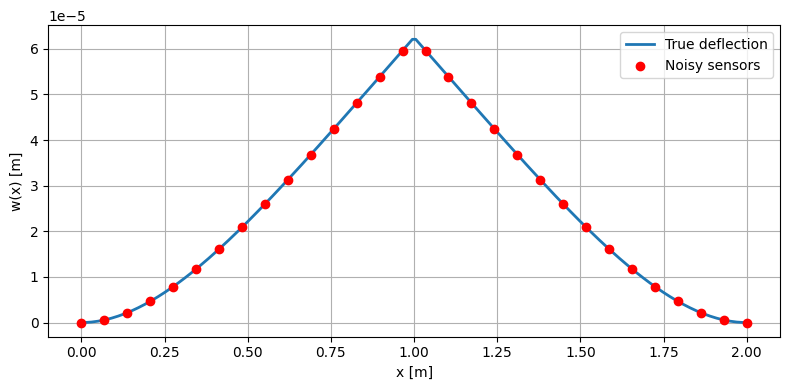

In [507]:
x_full = np.linspace(0, L, 200)

w_true = w(x_full, L, Q)
w_true = w_udl_hinge(x_full, hinge_loc, L, Q)
#w_true = w(x_full, L, Q)

x_sensors = np.linspace(0, L, 30)
w_sensors_clean = w_udl_hinge(x_sensors, hinge_loc, L, Q)
#w_sensors_clean = w(x_sensors, L, Q)
w_sensors = w_sensors_clean

if Noise:
  np.random.seed(42)
  noise_std = 0.05 * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)
plt.scatter(x_sensors, w_sensors, color='red', label="Noisy sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#2

In [508]:
x_sensors_norm = (x_sensors / L).reshape(-1, 1)
w_max = w_sensors_clean.max()  # still use clean max for scaling
w_sensors_norm = (w_sensors / w_max).reshape(-1, 1)

x_tf = tf.convert_to_tensor(x_full_norm, dtype=tf.float32)
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)

q_hat_norm = tf.Variable(0.0, dtype=tf.float32)

In [509]:
model = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(128, activation='swish', dtype = tf.float32),
        keras.layers.Dense(128, activation='swish', dtype = tf.float32),
        keras.layers.Dense(128, activation='swish', dtype = tf.float32),
        keras.layers.Dense(2,)  #two outputs: deflection and discontinuity
    ])

optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
optimizer_q = keras.optimizers.Adam(learning_rate = 1e-3)

def get_model_w(inputs):
    return model(inputs)[:, 0:1]

def get_model_b(inputs):
    return tf.sigmoid(model(inputs)[:, 1:2])

In [510]:
def compute_derivatives_bc(x_input):        #continuous derivatives for boundary conditions
    with tf.GradientTape() as tape4:
        tape4.watch(x_input)
        with tf.GradientTape() as tape3:
            tape3.watch(x_input)
            with tf.GradientTape() as tape2:
                tape2.watch(x_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(x_input)
                    w_hat = get_model_w(x_input)
                dw = tape1.gradient(w_hat, x_input)
            d2w = tape2.gradient(dw, x_input)
        d3w = tape3.gradient(d2w, x_input)
    d4w = tape4.gradient(d3w, x_input)
    return w_hat, dw, d2w, d3w, d4w

def discrete_derivatives(x):

    dl_norm = tf.convert_to_tensor(dl / L, dtype = tf.float32)

    y_m2 = get_model_w(x - 2.0*dl_norm)
    y_m1 = get_model_w(x - 1.0*dl_norm)
    y_0  = get_model_w(x)
    y_p1 = get_model_w(x + 1.0*dl_norm)
    y_p2 = get_model_w(x + 2.0*dl_norm)

    d1 = (y_p1 - y_m1) / (2.0*dl_norm)

    d4 = (y_m2 - 4.0*y_m1 + 6.0*y_0 - 4.0*y_p1 + y_p2) / (dl_norm**4)

    return d1, d4

DISCRETE = False
if DISCRETE:
    compute_derivatives = discrete_derivatives
else:
    compute_derivatives = compute_derivatives_bc    #to use continuous derivatives for everything


In [511]:
beta = tf.constant(0.9, dtype=tf.float32)  # Smoothing factor

w_data = tf.Variable(1.0, dtype=tf.float32)
w_phys = tf.Variable(0.5, dtype=tf.float32)
w_bc = tf.Variable(1.0, dtype=tf.float32)

w_filter = tf.Variable(0.1, dtype=tf.float32)
w_spikes = tf.Variable(0.1, dtype=tf.float32)

w_all = tf.Variable(1.0, dtype=tf.float32)

Use_Average = True

In [512]:
@tf.function
def train_step_data():
    with tf.GradientTape(persistent=True) as tape:

        w_pred = get_model_w(x_sensors_tf)
        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        w_data.assign(1.0)
        w_bc.assign(0.1)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss

    variables = model.trainable_variables
    grads = tape.gradient(differentiable_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    *_, d4w_norm = compute_derivatives(x_sensors_tf)
    q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
    physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
    physics_loss = tf.reduce_mean(tf.square(physics_residual))
    filter_penalty = np.nan

    total_loss = sum([data_loss, bc_loss, physics_loss])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty, d4w_norm


In [513]:
@tf.function
def train_step_filter(x_colloc, d4w_norm):
    with tf.GradientTape(persistent=True) as tape:

        b_pred = get_model_b(x_colloc)
        q_hat_tf = tf.ones_like(b_pred) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
        filter_penalty = tf.exp( 10 * filter_penalty)

        tv_b = b_pred[1:] - b_pred[:-1]
        tv_b = tf.reduce_mean(tf.abs(tv_b))

        w_phys.assign(0.1)
        w_filter.assign(0.1)
        w_spikes.assign(0.1)
        
        differentiable_loss = w_phys * physics_loss + w_filter * filter_penalty + w_spikes * tv_b

    grads_b = tape.gradient(differentiable_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads_b, model.trainable_variables))

    return physics_loss, filter_penalty

In [514]:
@tf.function
def train_step_intermediate(x_colloc): # still not updating q
    with tf.GradientTape(persistent=True) as tape:

        w_pred = get_model_w(x_sensors_tf)
        b_pred = get_model_b(x_colloc)

        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

        *_, d4w_norm = compute_derivatives(x_colloc)
        q_hat_tf = tf.ones_like(b_pred) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        filtered_residual = b_pred * physics_residual

        physics_loss = tf.reduce_mean(tf.square(filtered_residual))
        spikes_penalty = tf.reduce_mean(tf.square(filtered_residual[1:] - filtered_residual[:-1]))
        
        filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
        filter_penalty = tf.exp(5 * filter_penalty)

        w_data.assign(5.0)
        w_bc.assign(0.1)
        w_phys.assign(0.002)
        w_spikes.assign(0.1)
        w_filter.assign(0.01)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss + w_spikes * spikes_penalty + w_filter * filter_penalty


    grads = tape.gradient(differentiable_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    total_loss = sum([data_loss, bc_loss, physics_loss, filter_penalty])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty

In [515]:
Use_Average = False

@tf.function
def train_step_final(x_colloc):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
            w_pred = get_model_w(x_sensors_tf)
            b_pred = get_model_b(x_colloc)

            data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

            w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0, 1.0], dtype=tf.float32))
            bc_loss = tf.reduce_mean(tf.square(w0)) + tf.reduce_mean(tf.square(dw0 / L))

            *_, d4w_norm = compute_derivatives(x_colloc)
            q_hat_tf = tf.ones_like(b_pred) * q_hat_norm
            physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
            filtered_residual = b_pred * physics_residual

            physics_loss = tf.reduce_mean(tf.square(filtered_residual))
            spikes_penalty = tf.reduce_mean(tf.square(filtered_residual[1:] - filtered_residual[:-1]))
            
            filter_penalty = tf.reduce_mean(tf.square(1 - b_pred))
            
        '''if False: #LR Annealing
            vars = model.trainable_variables
            vars_weights = [var for var in vars if ('kernel' in var.name) or ('weight:' in var.name)]

            grad_res = tape1.gradient(physics_loss, vars_weights)
            grad_data = tape1.gradient(data_loss, vars_weights)
            grad_bcs = tape1.gradient(bc_loss, vars_weights)
            grad_filter = tape1.gradient(filter_penalty, vars_weights)

            grad_res_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_res], axis=0)
            grad_data_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_data], axis=0)
            grad_bcs_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_bcs], axis=0)
            grad_filter_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_filter], axis=0)
            grad_all_flatten = grad_data_flatten + grad_bcs_flatten + grad_filter_flatten

            max_grad_res = tf.reduce_max(abs(grad_res_flatten))
            mean_grad_res = tf.reduce_mean(abs(grad_res_flatten))
            mean_grad_data = tf.reduce_mean(abs(grad_data_flatten))
            mean_grad_bcs = tf.reduce_mean(abs(grad_bcs_flatten))
            mean_grad_filter = tf.reduce_mean(abs(grad_filter_flatten))
            mean_grad_all = tf.reduce_mean(abs(grad_all_flatten))

            w_data_hat = max_grad_res / mean_grad_data
            w_bc_hat = max_grad_res / mean_grad_bcs
            w_filter_hat = mean_grad_res / mean_grad_filter
            w_all_hat = max_grad_res / mean_grad_all
            
            tf.print("max_grad:", max_grad_res)
            tf.print("mean_grad_data:", mean_grad_data)
            tf.print("mean_grad_bcs:", mean_grad_bcs)

            tf.print("w_data_hat:", w_data_hat)
            tf.print("w_bc_hat:", w_bc_hat)
            
            w_all.assign(w_all * beta + w_all_hat * (1 - beta))    
            
            w_data.assign(w_data * beta + w_data_hat * (1 - beta))
            w_phys.assign(1.0)
            w_bc.assign(w_bc * beta + w_bc_hat * (1 - beta))
            w_filter.assign(w_filter * beta + w_filter_hat * (1 - beta))
            
            w_filter.assign(tf.clip_by_value(w_filter, 0.01, 1000.0)) #adding cap to avoid exploding weights
            if Use_Average:
                w_data.assign(w_all)
                w_bc.assign(w_all)
                w_filter.assign(w_all)'''  
                
        w_data.assign(5.0)
        w_bc.assign(0.1)
        w_phys.assign(0.002)
        w_spikes.assign(0.1)
        w_filter.assign(0.01)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss + w_spikes * spikes_penalty + w_filter * filter_penalty


    grads = tape2.gradient(differentiable_loss, model.trainable_variables)
    grads_q = tape2.gradient(differentiable_loss, [q_hat_norm])

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    optimizer_q.apply_gradients(zip(grads_q, [q_hat_norm]))

    total_loss = sum([data_loss, bc_loss, physics_loss, filter_penalty])
    return total_loss, data_loss, bc_loss, physics_loss, filter_penalty

In [516]:
Data_only = False

N_DATA = 20000
N_FILTER = 5000
N_INTERM = 5000
N_INTEGRATE = 40000

history = {"loss": [], "data": [], "phys": [], "bc": [], "filter": [], "q_hat_norm": []}

In [517]:
for epoch in range(N_DATA + N_FILTER + N_INTERM + N_INTEGRATE):

    if epoch < N_DATA:
      loss, data_l, bc_l, phys_l, filter_l, d4w_norm = train_step_data()
      
    elif epoch == N_DATA:
      print("Freezing everything except the last layer")
      for l in model.layers:
        l.trainable = False
      model.layers[-1].trainable = True   #to only train the last layer
      
      *_, d2w_full_norm, _, d4w_full_norm = compute_derivatives(x_tf)
      
      max_moment_loc = x_tf[tf.argmax(tf.abs(d2w_full_norm))]
      hinge_start = max_moment_loc - colloc_width / 2.
      hinge_end = max_moment_loc + colloc_width / 2.
      if USE_COLLOC:
        x_colloc = get_collocation_points(x_sensors_tf, max_moment_loc, colloc_width, colloc_density)
      else:
        x_colloc = x_sensors_tf
        
      *_, d4w_norm = compute_derivatives(x_colloc)
      tf.print("Max moment at", max_moment_loc)
      
    elif epoch < N_DATA + N_FILTER:
      phys_l, filter_l = train_step_filter(x_colloc, tf.stop_gradient(d4w_norm))
      data_l, bc_l = tf.cast(history["data"][-1], tf.float32), tf.cast(history["bc"][-1], tf.float32)
      loss = phys_l + filter_l + data_l + bc_l
      
    elif epoch < N_DATA + N_FILTER + N_INTERM:
      if epoch == N_DATA + N_FILTER:
        print("Unfreezing")
        for l in model.layers:
          l.trainable = True
          
      loss, data_l, bc_l, phys_l, filter_l = train_step_intermediate(x_colloc)
      
    else:
      loss, data_l, bc_l, phys_l, filter_l = train_step_final(x_colloc)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.6f} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | BC: {bc_l.numpy().item():.6f}| Filter: {filter_l.numpy().item():.6f}| Predicted q: {q_hat_norm.numpy()}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["filter"].append(filter_l.numpy().item())
    history["q_hat_norm"].append(q_hat_norm.numpy().item())

Epoch     0 | Total: 0.268415 | Data: 0.268360 | Phys: 0.000000 | BC: 0.000055| Filter: nan| Predicted q: 0.0
Epoch  1000 | Total: 80.879349 | Data: 0.000668 | Phys: 80.878403 | BC: 0.000275| Filter: nan| Predicted q: 0.0
Epoch  2000 | Total: 87.804512 | Data: 0.000643 | Phys: 87.803574 | BC: 0.000300| Filter: nan| Predicted q: 0.0
Epoch  3000 | Total: 99.743950 | Data: 0.000634 | Phys: 99.742805 | BC: 0.000511| Filter: nan| Predicted q: 0.0
Epoch  4000 | Total: 128.837112 | Data: 0.000541 | Phys: 128.836258 | BC: 0.000324| Filter: nan| Predicted q: 0.0
Epoch  5000 | Total: 199.437134 | Data: 0.000439 | Phys: 199.436432 | BC: 0.000263| Filter: nan| Predicted q: 0.0
Epoch  6000 | Total: 1823.587158 | Data: 0.000113 | Phys: 1823.587036 | BC: 0.000039| Filter: nan| Predicted q: 0.0
Epoch  7000 | Total: 6035.025879 | Data: 0.000331 | Phys: 6035.023926 | BC: 0.001473| Filter: nan| Predicted q: 0.0
Epoch  8000 | Total: 9029.944336 | Data: 0.000024 | Phys: 9029.944336 | BC: 0.000001| Filter: 

In [518]:
w_hat, dw, d2w, d3w, d4w = compute_derivatives_bc(x_tf)
#*_, d4w = discrete_derivatives(x_tf)

b_pred = get_model_b(x_tf)
w_pred = w_hat.numpy() * w_max
q_dim = q_hat_norm.numpy()
q_pred = q_dim.flatten()
q_pred = q_pred * Q

R² score (PINN Model): 0.99991


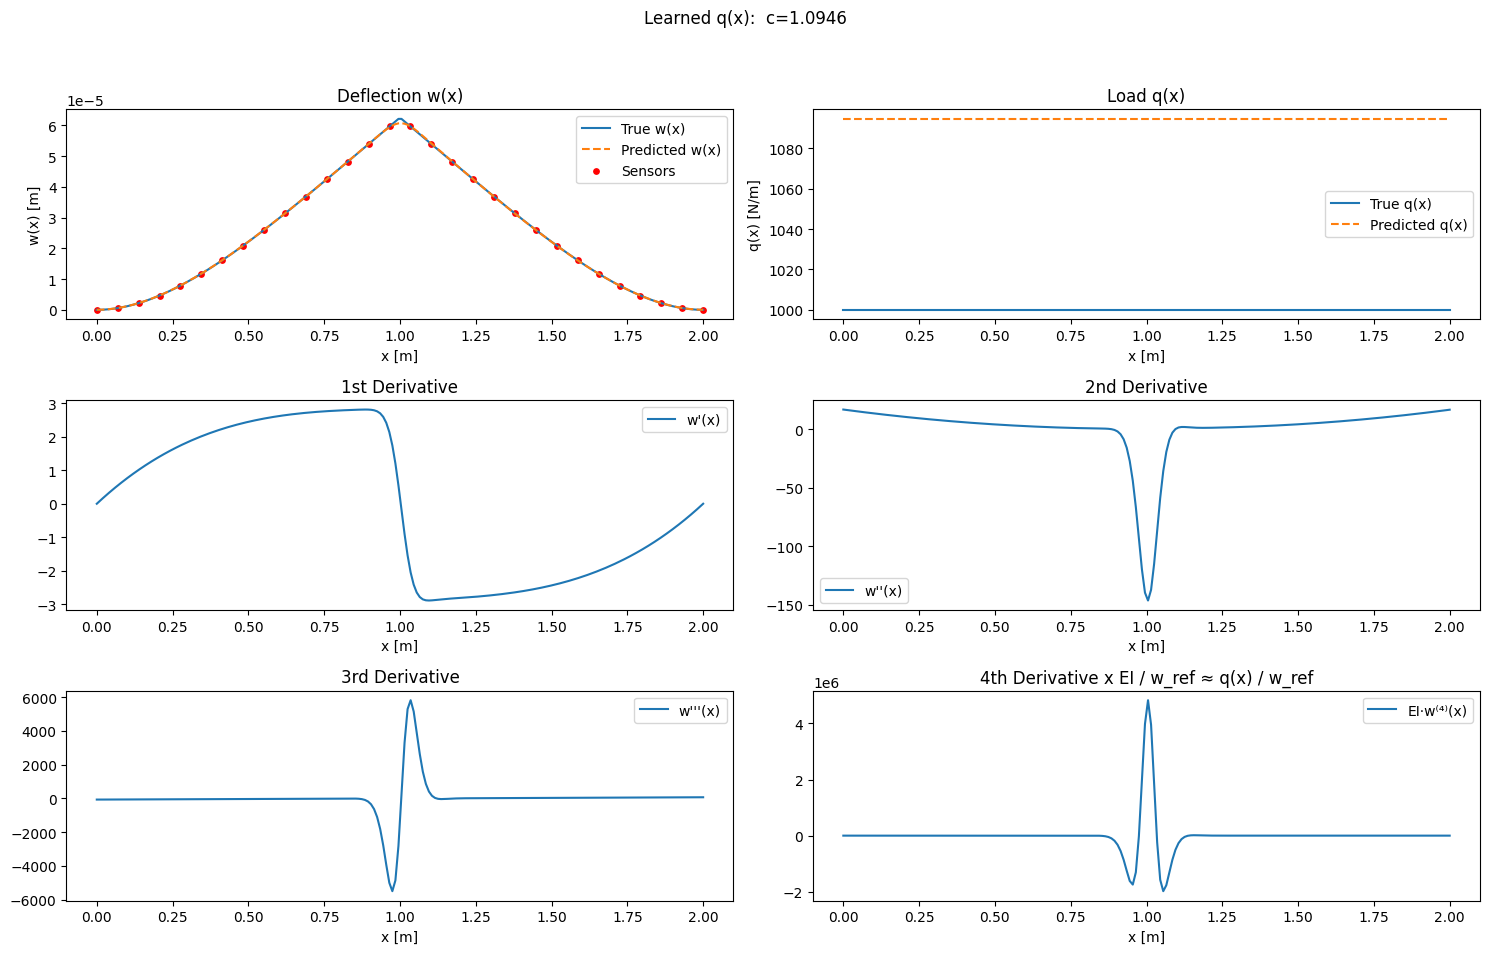

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0945526361465454>

In [519]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values
#w_true = w_point_load(x_plot)  # True analytical deflection
q_true = Q * np.ones_like(x_plot)  # Constant uniform load

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, np.full_like(x_plot, q_pred), '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot, d4w * w_max / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative x EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()
plt.suptitle(f"Learned q(x):  c={q_dim:.4f}")

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²


q_hat_norm

tf.Tensor(0.50753766, shape=(), dtype=float32)


Text(0.5, 1.0, 'Physics Residual Squared')

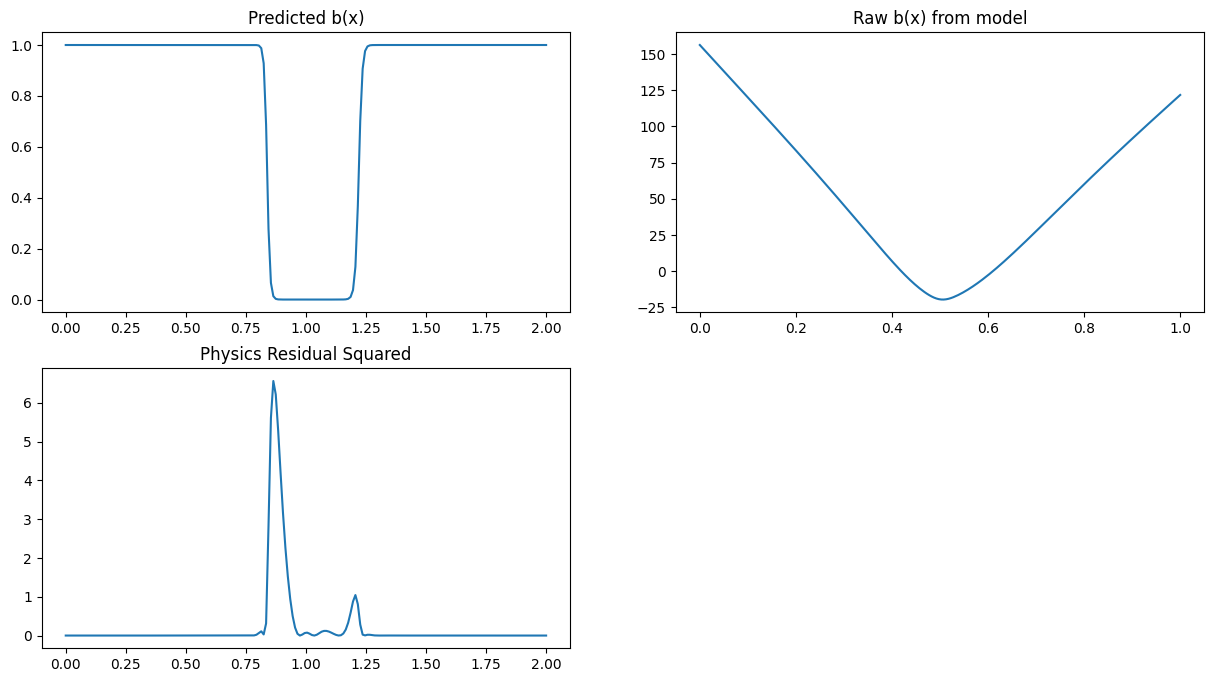

In [549]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
plt.plot(x_full, b_pred)
plt.title("Predicted b(x)")

plt.subplot(222)
b_raw = model(x_tf)[:, 1]
plt.plot(x_tf, (b_raw))
plt.title("Raw b(x) from model")
print(x_tf[tf.argmin(b_raw)])

plt.subplot(223)
plt.plot(x_full,(tf.squeeze(b_pred) *  tf.square(d4w * (EI * w_max / (L**4 * Q)) - q_hat_norm)))
plt.title("Physics Residual Squared")



Text(0.5, 1.0, 'q_hat_norm over epochs')

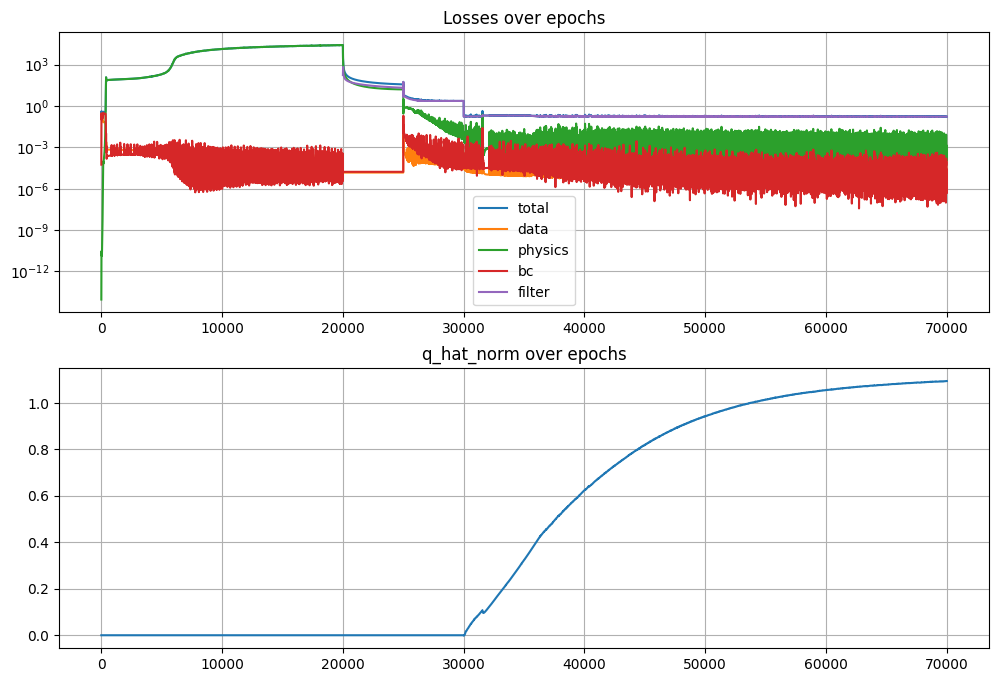

In [547]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(history['loss'], label = 'total')
plt.plot(history['data'], label = 'data')
plt.plot(history['phys'], label = 'physics')
plt.plot(history['bc'], label = 'bc')
plt.plot(history['filter'], label = 'filter')
plt.legend()
plt.grid(True)
plt.title("Losses over epochs")
plt.yscale('log')

plt.subplot(212)
plt.plot(history['q_hat_norm'])
plt.grid(True)
plt.title("q_hat_norm over epochs")